# NPM Kompleks Ağ Analizi (Top 200)

Bu defter, popüler Top 200 NPM paketini yönlü bir ağ (Dependent → Dependency) olarak modelleyip, in-degree ve betweenness merkeziyet metrikleriyle yapısal riski inceler. Kurulum adımlarını atlıyoruz; gerekli paketlerin yüklü olduğu varsayılır.

- Veri: API'den çekilen Top N paket (varsayılan 200)
- Ağ: NetworkX DiGraph, kenarlar Dependent → Dependency
- Metrikler: In-degree, Betweenness
- Çıktılar: `results/` altına kaydedilir
- Görselleştirme: Tüm ağ ve sadece Top 200 indüklenmiş alt-ağ

Not: Büyük N (ör. 20k) için bağımlılık çekimi ve betweenness hesabı maliyetlidir; bu defter Top 200 için optimize edilmiştir.

## 1) İçe Aktarım ve Parametreler
Yardımcı fonksiyonlar `src/analyze_npm_network.py` içindedir. Varsayılan `OUTDIR` = `results/`.

In [1]:
from pathlib import Path
import sys
import os

# src klasörünü import yoluna ekle
sys.path.append(str(Path('src').resolve()))

import networkx as nx
from analysis_helpers import (
    fetch_top_packages,
    build_dependency_graph,
    compute_metrics,
    save_edges,
    save_metrics,
    save_report,
    read_list,
)

# Tercihen sabit Top 200 listesi
TOP_N = 200  # gerekirse API'den çekmek için yedek
OUTDIR = Path('results')
OUTDIR.mkdir(parents=True, exist_ok=True)
OUTDIR

WindowsPath('results')

## 2) Top 200 Paketleri Yükle
`data/top_200.txt` varsa kullan; yoksa API’lerden Top‑N çek.

In [2]:
top_packages = fetch_top_packages(TOP_N)
print(f'API’lerden {len(top_packages)} paket çekildi')
len(top_packages), top_packages[:20]

API’lerden 200 paket çekildi


(200,
 ['semver',
  'ansi-styles',
  'debug',
  'chalk',
  'minimatch',
  'supports-color',
  'strip-ansi',
  'ms',
  'ansi-regex',
  'tslib',
  'string-width',
  'brace-expansion',
  'lru-cache',
  'commander',
  'type-fest',
  'wrap-ansi',
  'glob',
  'emoji-regex',
  'color-convert',
  'source-map'])

## 3) Yönlü Ağı Kur
Düğümler paketler; kenarlar Dependent → Dependency. Varsayılan olarak yalnızca `dependencies` kullanılır.

In [3]:
G, top_set = build_dependency_graph(top_packages)
G.number_of_nodes(), G.number_of_edges()

(273, 237)

## 4) Merkeziyet Metrikleri
- In-Degree: Düğüme gelen kenar → etkilenebilecek alan
- Out-Degree: Düğümün dış bağımlılık sayısı → bağımlılık zinciri uzunluğu
- Betweenness: En kısa yollardaki aracılık → tek hata noktası riski

In [4]:
in_deg, out_deg, btw = compute_metrics(G)
nodes = G.number_of_nodes(); edges = G.number_of_edges()
nodes, edges

(273, 237)

## 5) İlk 15 (Tüm Düğümler ve Kohort)
In-degree ve betweenness açısından liderlere hızlı bakış (tüm düğümler ve sadece Top 200).

In [5]:
top_in_all = sorted(in_deg.items(), key=lambda kv: kv[1], reverse=True)[:15]
top_btw_all = sorted(btw.items(), key=lambda kv: kv[1], reverse=True)[:15]
top_in_top = sorted(((n, in_deg.get(n, 0)) for n in top_set), key=lambda kv: kv[1], reverse=True)[:15]
top_btw_top = sorted(((n, btw.get(n, 0.0)) for n in top_set), key=lambda kv: kv[1], reverse=True)[:15]
top_in_all, top_btw_all, top_in_top, top_btw_top

([('@babel/types', 5),
  ('debug', 4),
  ('@babel/parser', 4),
  ('@babel/code-frame', 4),
  ('strip-ansi', 3),
  ('tslib', 3),
  ('string-width', 3),
  ('picomatch', 3),
  ('@types/node', 3),
  ('hasown', 3),
  ('unicorn-magic', 3),
  ('ansi-styles', 2),
  ('chalk', 2),
  ('path-key', 2),
  ('agent-base', 2)],
 [('@babel/code-frame', 0.00018314521380507923),
  ('@jest/types', 0.00016279574560451487),
  ('fast-glob', 0.00016279574560451487),
  ('jest-util', 0.0001492294334708053),
  ('micromatch', 0.00013566312133709573),
  ('@babel/generator', 0.00013566312133709573),
  ('braces', 0.00012209680920338616),
  ('@babel/types', 0.00011531365313653136),
  ('fill-range', 0.00010853049706967658),
  ('glob', 9.4964184935967e-05),
  ('form-data', 9.4964184935967e-05),
  ('parse-json', 9.4964184935967e-05),
  ('@jridgewell/trace-mapping', 7.461471673540265e-05),
  ('to-regex-range', 6.783156066854787e-05),
  ('cross-spawn', 6.104840460169308e-05)],
 [('@babel/types', 5),
  ('debug', 4),
  ('@ba

## 6) Sonuçları Kaydet
Kenarlar, metrikler ve kısa rapor `results/` altına yazılır.

In [6]:
save_edges(G, OUTDIR / 'edges.csv')
save_metrics(in_deg, out_deg, btw, top_set, OUTDIR / 'metrics.csv')
save_report(in_deg, out_deg, btw, top_set, OUTDIR / 'report.md')
(OUTDIR / 'top_packages.txt').write_text(os.linesep.join(top_packages), encoding='utf-8')
sorted(OUTDIR.iterdir())

[WindowsPath('results/edges.csv'),
 WindowsPath('results/metrics.csv'),
 WindowsPath('results/report.md'),
 WindowsPath('results/top_packages.txt')]

## 7) Hızlı Doğrulama
Rastgele bazı paketler için registry’deki `dependencies` ile graf kenarlarını karşılaştıralım. Küçük farklar sürüm farklılıklarından kaynaklanabilir.

In [7]:
import random, requests, urllib.parse
def get_registry_deps(name: str):
    url = f'https://registry.npmjs.org/{urllib.parse.quote(name, safe="")}'
    r = requests.get(url, timeout=30)
    if r.status_code != 200:
        return {}
    data = r.json()
    latest = (data.get('dist-tags') or {}).get('latest')
    versions = data.get('versions') or {}
    obj = versions.get(latest) if latest in versions else {}
    return obj.get('dependencies') or {}

sample = random.sample(top_packages, k=min(5, len(top_packages)))
mismatches = {}
for pkg in sample:
    deps_live = set(get_registry_deps(pkg).keys())
    deps_graph = set(v for u,v in G.out_edges(pkg))
    if deps_live != deps_graph:
        mismatches[pkg] = {
            'live_only': sorted(list(deps_live - deps_graph)),
            'graph_only': sorted(list(deps_graph - deps_live)),
        }
mismatches

{}

## 8) Tüm Ağ Çizimi (Top 200 + Bağımlılıklar)
Top 200 düğümleri turuncu, diğerleri mavi; düğüm boyutu in-degree ile ölçeklenir.

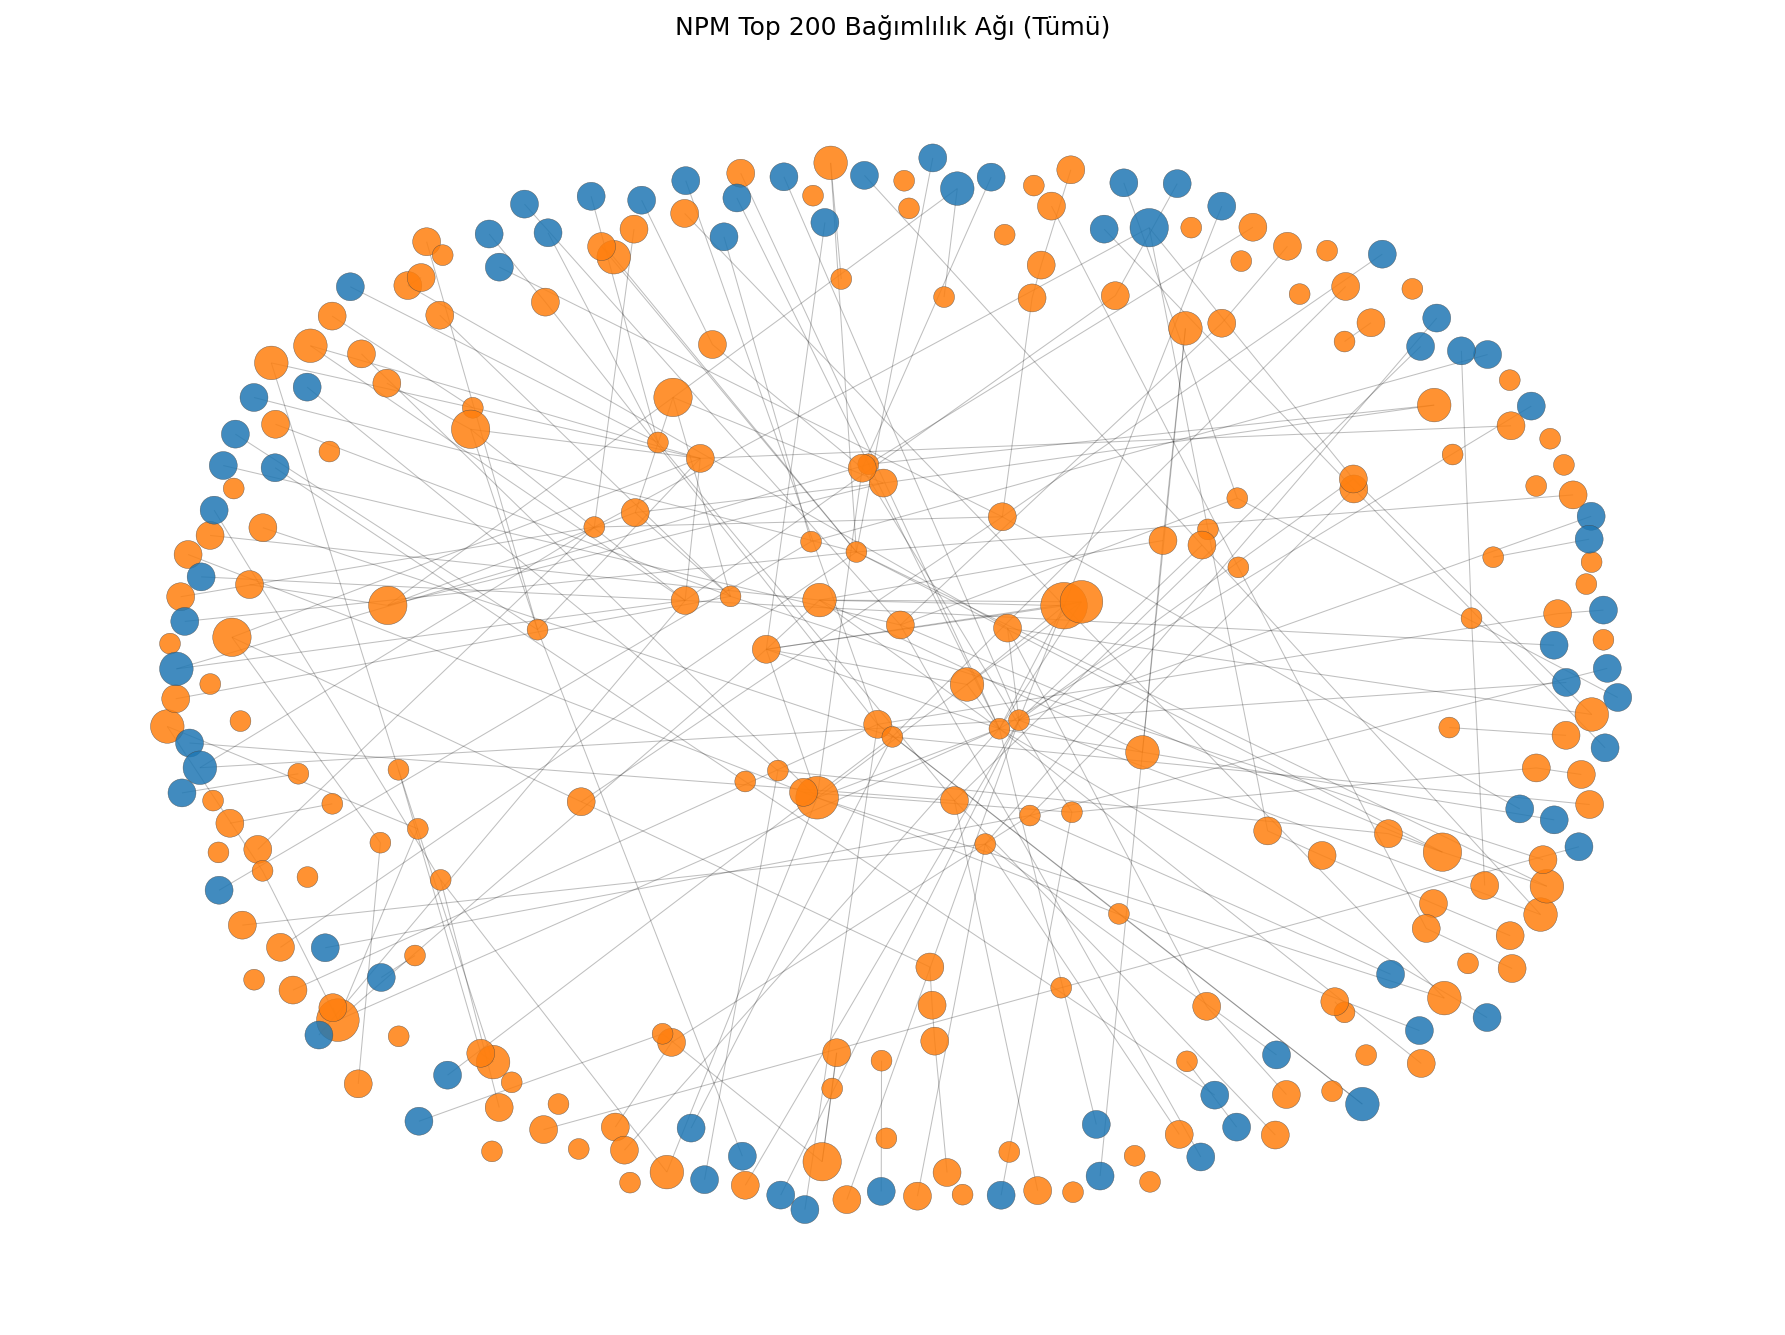

In [8]:
import math
try:
    import matplotlib.pyplot as plt
    N = G.number_of_nodes()
    pos = nx.spring_layout(G, k=1/math.sqrt(max(N,1)), seed=42)
    max_in = max(in_deg.values()) if in_deg else 1
    node_sizes = [100 + (400 * (in_deg.get(n,0) / max_in if max_in else 0)) for n in G.nodes()]
    node_colors = ['tab:orange' if n in top_set else 'tab:blue' for n in G.nodes()]
    plt.figure(figsize=(12, 9), dpi=150)
    nx.draw_networkx_edges(G, pos, arrows=False, width=0.5, alpha=0.25)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85, linewidths=0.2, edgecolors='#444444')
    plt.title('NPM Top 200 Bağımlılık Ağı (Tümü)')
    plt.axis('off')
    out_png = OUTDIR / 'network_full_top200.png'
    out_svg = OUTDIR / 'network_full_top200.svg'
    plt.tight_layout(); plt.savefig(out_png); plt.savefig(out_svg)
    (out_png, out_svg)
except ModuleNotFoundError:
    print('matplotlib bulunamadı; görselleştirme atlandı.')


## 9) Sadece Top 200 (İndüklenmiş Alt-Ağ)
Sadece Top 200 düğümleri; düğüm sayısı azsa etiketleri göster.

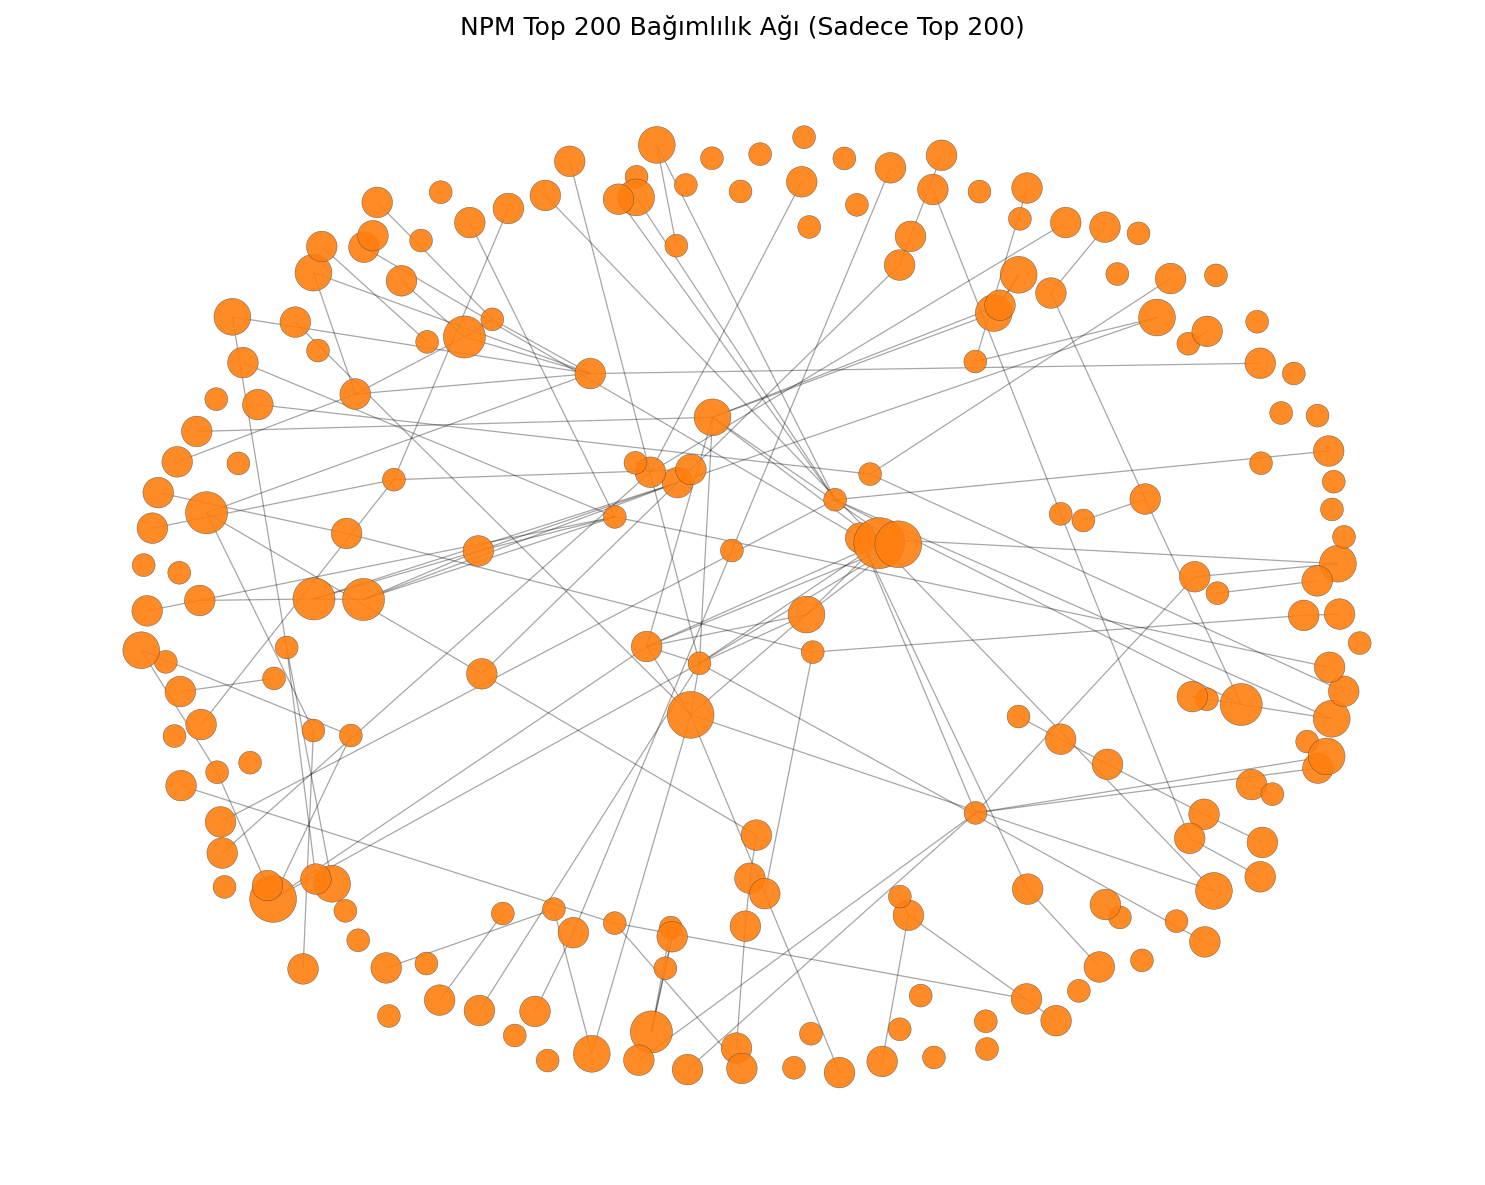

In [9]:
try:
    H = G.subgraph(top_set).copy()
    HN = H.number_of_nodes() or 1
    posH = nx.spring_layout(H, k=1/math.sqrt(HN), seed=42)
    max_in_H = max((in_deg.get(n,0) for n in H.nodes()), default=1)
    node_sizes_H = [120 + (480 * (in_deg.get(n,0) / max_in_H if max_in_H else 0)) for n in H.nodes()]
    node_colors_H = ['tab:orange' for _ in H.nodes()]
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8), dpi=150)
    nx.draw_networkx_edges(H, posH, arrows=False, width=0.6, alpha=0.35)
    nx.draw_networkx_nodes(H, posH, node_size=node_sizes_H, node_color=node_colors_H, alpha=0.9, linewidths=0.2, edgecolors='#444444')
    if H.number_of_nodes() <= 60:
        nx.draw_networkx_labels(H, posH, font_size=6)
    plt.title('NPM Top 200 Bağımlılık Ağı (Sadece Top 200)')
    plt.axis('off')
    out_png2 = OUTDIR / 'network_top200_only.png'
    out_svg2 = OUTDIR / 'network_top200_only.svg'
    plt.tight_layout(); plt.savefig(out_png2); plt.savefig(out_svg2)
    (out_png2, out_svg2)
except ModuleNotFoundError:
    print('matplotlib bulunamadı; görselleştirme atlandı.')


## 10) Varsayımlar ve Sınırlamalar
- Kenar yönü Dependent → Dependency; yayılım analizi için uygundur.
- Varsayılan olarak yalnızca `dependencies` dahil; `peerDependencies` talebe göre eklenebilir.
- Küresel dependent sayıları dahil değildir; ecosyste.ms’ten eklenebilir.
- En güncel sürüm kullanılır; eski sürümlerde bağımlılıklar farklı olabilir.

## 11) Liderler: İlk 10 (Görselleştirme)
In-degree ve betweenness için ilk 10 paketi çubuk grafiklerle gösterelim.

results\top10_leaders.png


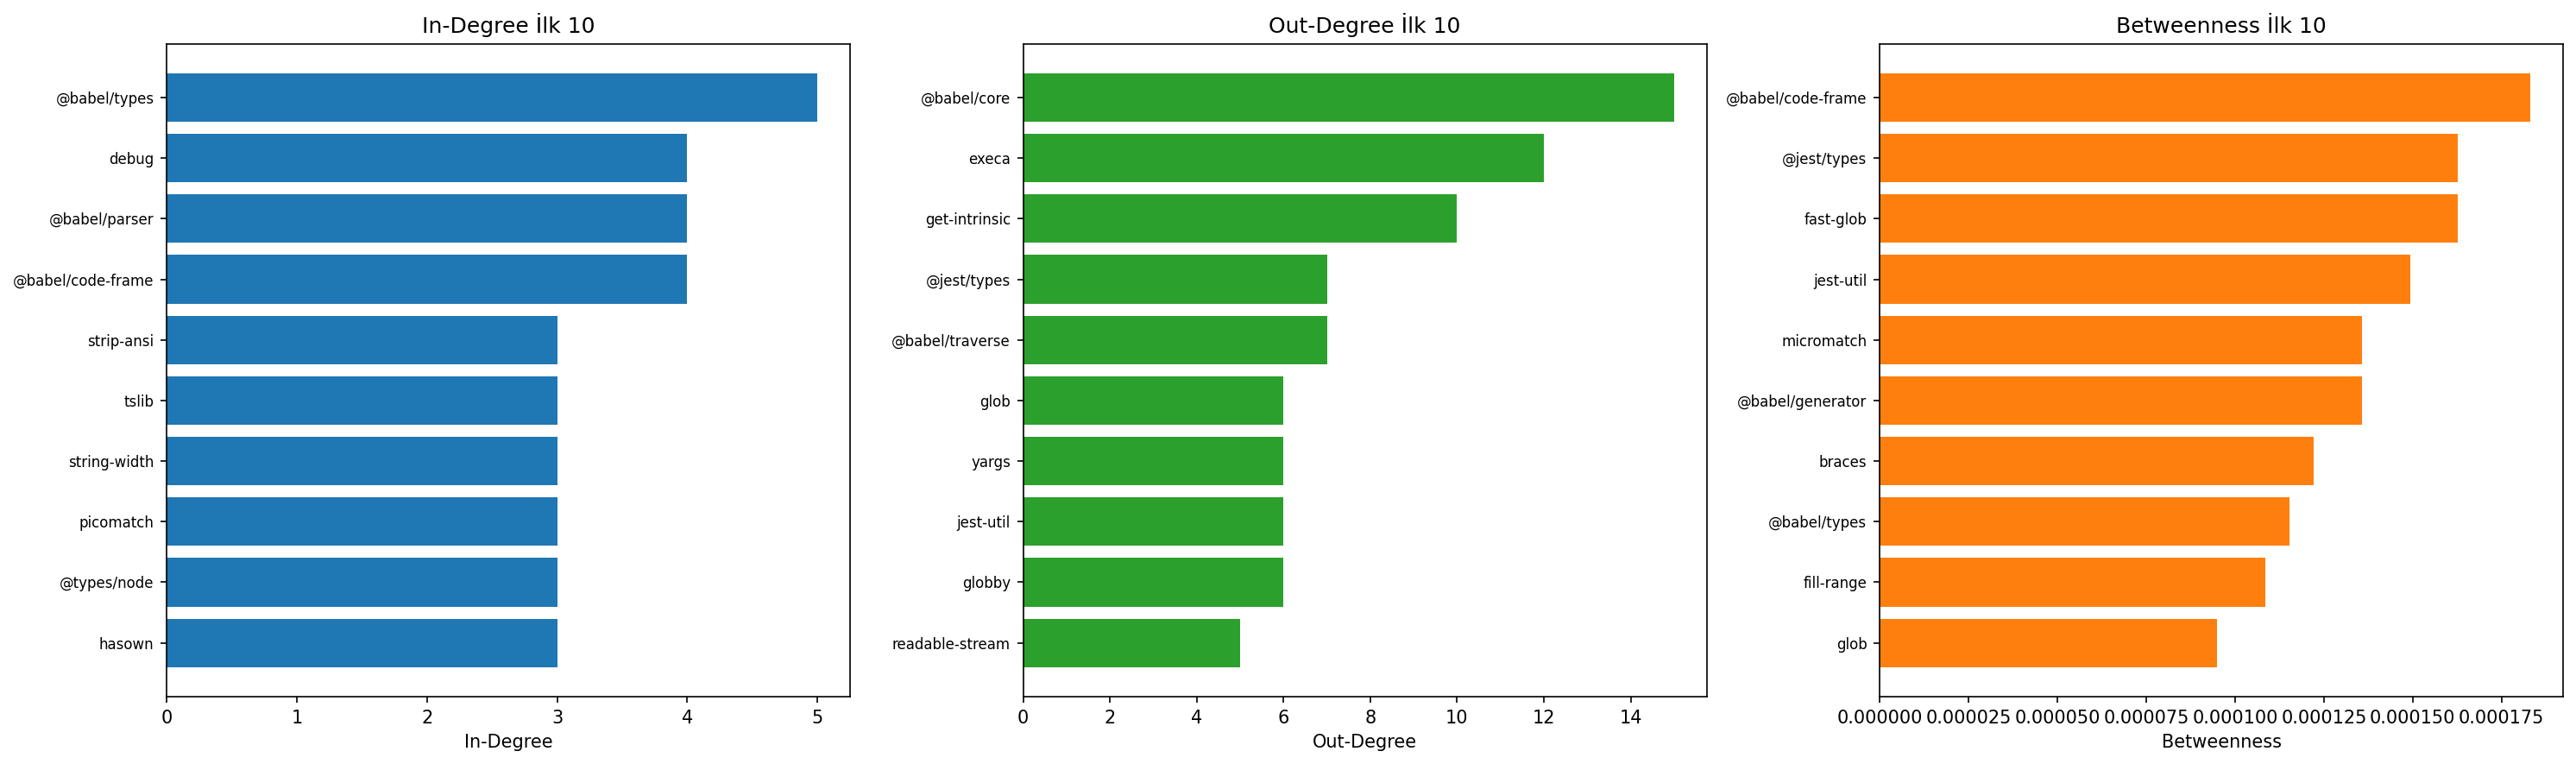

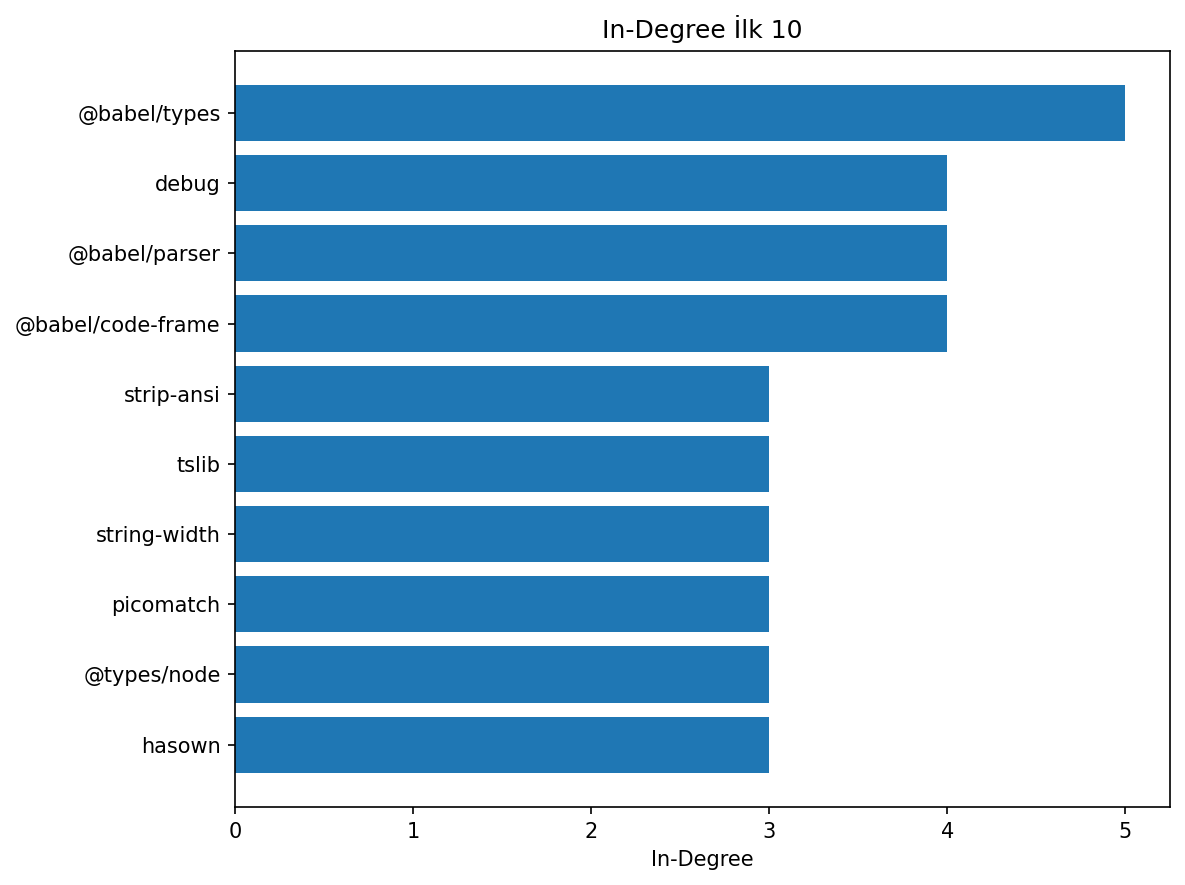

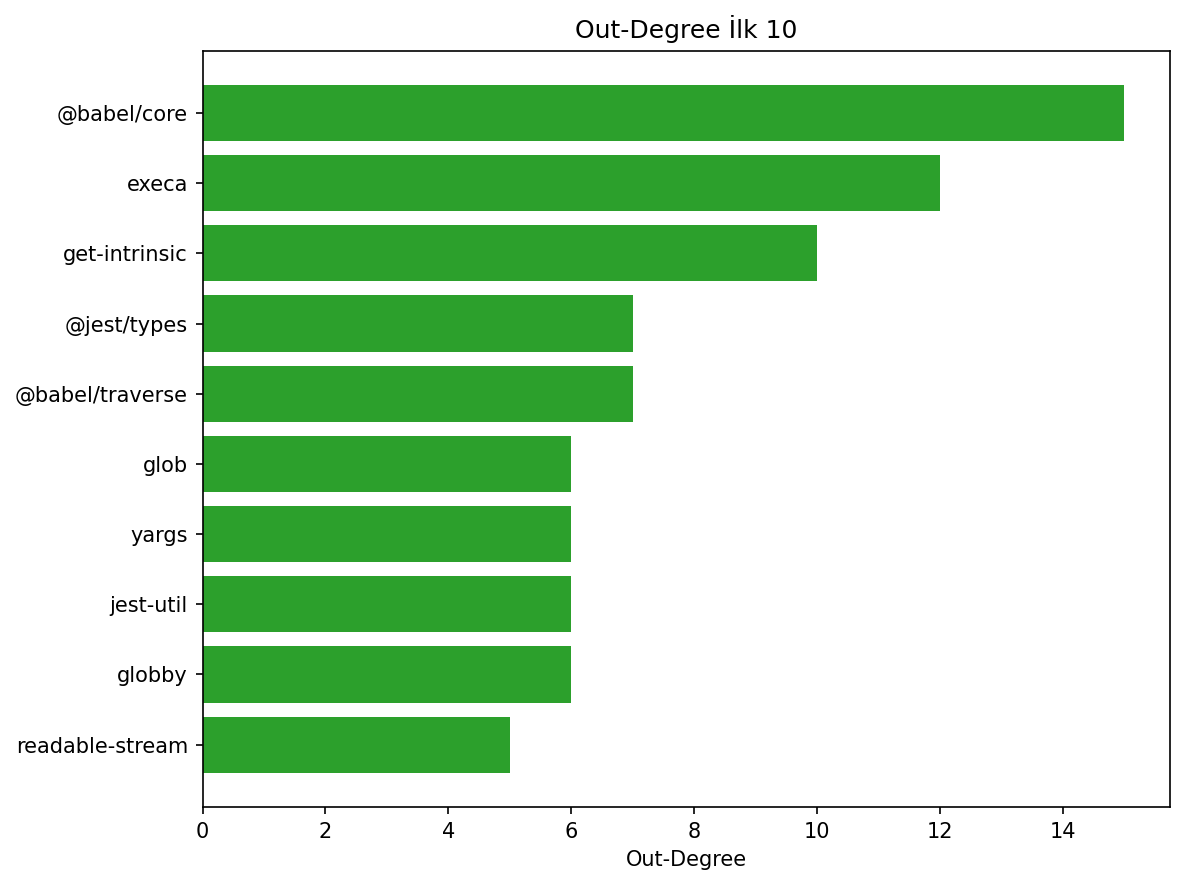

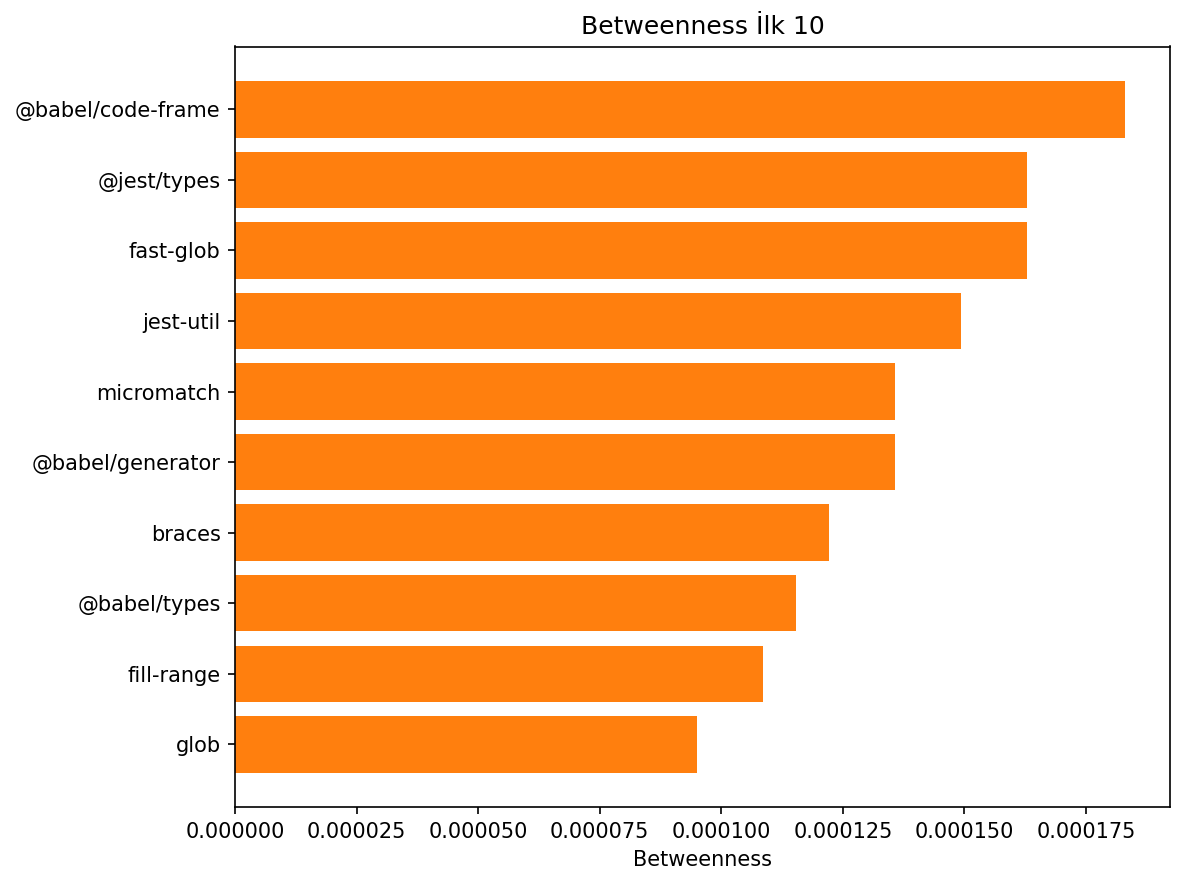

In [10]:
try:
    import matplotlib.pyplot as plt
    # In-Degree ilk 10 (tüm düğümler)
    top10_in = sorted(in_deg.items(), key=lambda kv: kv[1], reverse=True)[:10]
    names_in = [n for n,_ in top10_in][::-1]
    vals_in = [v for _,v in top10_in][::-1]

    # Out-Degree ilk 10 (tüm düğümler)
    top10_out = sorted(out_deg.items(), key=lambda kv: kv[1], reverse=True)[:10]
    names_out = [n for n,_ in top10_out][::-1]
    vals_out = [v for _,v in top10_out][::-1]

    # Betweenness ilk 10 (tüm düğümler)
    top10_btw = sorted(btw.items(), key=lambda kv: kv[1], reverse=True)[:10]
    names_btw = [n for n,_ in top10_btw][::-1]
    vals_btw = [v for _,v in top10_btw][::-1]

    fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=150)
    # In-Degree grafiği
    axes[0].barh(names_in, vals_in, color='tab:blue')
    axes[0].set_title('In-Degree İlk 10')
    axes[0].set_xlabel('In-Degree')
    axes[0].tick_params(axis='y', labelsize=8)

    # Out-Degree grafiği
    axes[1].barh(names_out, vals_out, color='tab:green')
    axes[1].set_title('Out-Degree İlk 10')
    axes[1].set_xlabel('Out-Degree')
    axes[1].tick_params(axis='y', labelsize=8)

    # Betweenness grafiği
    axes[2].barh(names_btw, vals_btw, color='tab:orange')
    axes[2].set_title('Betweenness İlk 10')
    axes[2].set_xlabel('Betweenness')
    axes[2].tick_params(axis='y', labelsize=8)

    plt.tight_layout()
    out_combo = OUTDIR / 'top10_leaders.png'
    plt.savefig(out_combo)
    print(out_combo)

    # Ayrı ayrı da kaydedelim
    plt.figure(figsize=(8,6), dpi=150); plt.barh(names_in, vals_in, color='tab:blue'); plt.title('In-Degree İlk 10'); plt.xlabel('In-Degree'); plt.tight_layout(); plt.savefig(OUTDIR / 'top10_in_degree.png')
    plt.figure(figsize=(8,6), dpi=150); plt.barh(names_out, vals_out, color='tab:green'); plt.title('Out-Degree İlk 10'); plt.xlabel('Out-Degree'); plt.tight_layout(); plt.savefig(OUTDIR / 'top10_out_degree.png')
    plt.figure(figsize=(8,6), dpi=150); plt.barh(names_btw, vals_btw, color='tab:orange'); plt.title('Betweenness İlk 10'); plt.xlabel('Betweenness'); plt.tight_layout(); plt.savefig(OUTDIR / 'top10_betweenness.png')
except ModuleNotFoundError:
    print('matplotlib bulunamadı; görselleştirme atlandı.')